# The realization of a dream: open a Sushi Bar in Bologna

### Applied Data Science Capstone by IBM/Coursera

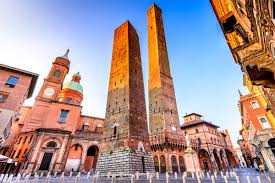

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Bologna's neighborhoods](#neighborhoods)
* [Credentials and Version](#credentials)
* [Explore the University of Bologna's neighborhood](#university)
* [Explore Bologna's Neighborhoods](#exploreneighborhoods)
* [Analyze Each Neighborhood](#analyzeneighborhoods)
* [Considerations](#someconsiderations)
* [Santo Stefano](#santostefano)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

An old aunt left a nice nest egg to the undersigned: 3 million euros. I can finally realize my dream: to open a trendy restaurant in one of the most beautiful Italian cities.
I have always worked in the world of catering and I am doing well in the kitchen. To follow my dreams I went to Japan and spent 5 wonderful years learning the secrets of Sushi. Also I love being among young people. So my dream is to open a Sushi Bar in a university city where there are many young people. The choice falls on Bologna, a city full of young people with a historical university. The opening price may be lower than in other cities. There would be competition in any case because Bologna is full of clubs. There are not as many foreign tourists as in Rome or Milan, so opening in Bologna would have this penalty. But the city is sensitive to news and this is a plus.<br/>
Since I am convinced of my skills and the fact that my Sushi bar can offer something better than the competition, I will try to rent the place where there is a greater concentration of restaurants and possibly Sushi Bars.
Obviously I will try to stay as close as possible to the center, compatibly with the cost of the rent. <br/>
I will try to identify areas with the biggest concentation of young people. <br/>

This study will help anyone who wants to start a restaurant business in a young and dynamic city like Bologna
The business plan that will be illustrated has a general value: anyone who wants to open a restaurant somewhere will find the illustrated methodology and the examples provided useful. The considerations made can be applied to any city and to any type of restaurant / pub / caffee shop etc etc.

## Data <a name="data"></a>

The following data sources will be needed to extract/generate the required information:
* A Pandas dataframe will be provided with some data about the main Bologna's neighborhoods (name, density of inhabitants, distance from the University, cost of rent)
* The dataframe will be enriched by the centers of candidate areas that will be generated algorithmically and approximate addresses of centers of those areas will be obtained using Google Maps API reverse geocoding.
* Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API. Through a Bubble Chart it will be possible to identify the areas with the highest concentration of restaurants.
* The list of Sushi Bars in the Bologna neighbourhoods and their location with respect to the city center will retrieved using Foursquare API.
* For each Sushi Bar I will analyze the number of clicks received and the comments. From these data I will be able to understand the age of the clientele in relation the position of the restaurant itself.

The area where the Sushi Bar will be opened will be chosen according to the following criteria:
    - density of restaurants
    - density of competitor Sushi bars
    - distance from the University
    - density of young population


## Bologna's neighborhoods<a name="neighborhoods"></a>

Let's retrieve the Bologna's neighborhoods data. Wea regoing to use the 'pd.read_html'. It returns a list of objects containing the info grabbed from the html page.In this  case the Dataframe we are looking for is contained in the first object of the list.

In [4]:
import pandas as pd
import numpy as np

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [5]:
url_html='https://it.wikipedia.org/wiki/Quartieri_di_Bologna'
bologna_obj = pd.read_html(url_html)
bologna_df = bologna_obj[0]
bologna_df.head()

,Quartiere,Superficie (km²),Abitanti[2],Densità (ab/km²),Suddivisioni,Presidente
0,Borgo Panigale-Reno,31436,61.141,194494.00000,"Borgo Panigale, Casteldebole, La Birra, Barca,...",Vincenzo Naldi [3] (Partito Democratico)
1,San Donato-San Vitale,26268,66.297,2.52387,"San Donato, San Vitale, San Donnino, Pilastro,...",Simone Borsari [4] (centrosinistra)
2,Navile,25875,69.187,2.67389,"Lame, Corticella, Bolognina",Daniele Ara [4](centrosinistra)
3,Porto-Saragozza,15766,69.477,4.40676,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",Lorenzo Cipriani (centrosinistra)
4,Santo Stefano,30040,64.258,2.13908,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",Rosa Maria Amorevole [5] (centrosinistra)


Some tuning is required on the dataframe. Let's start dropping unuseful columns.

In [6]:
bologna_df = bologna_df.drop(['Presidente'], axis=1)

Now let's rename the column's name from italian to english

In [7]:
print(bologna_df.columns)
bologna_df.columns = ['neighborhood', 'area', 'inhabitants', 'density', 'sub district']
bologna_df.head()

Index(['Quartiere', 'Superficie (km²)', 'Abitanti[2]', 'Densità (ab/km²)',
       'Suddivisioni'],
      dtype='object')


,neighborhood,area,inhabitants,density,sub district
0,Borgo Panigale-Reno,31436,61.141,194494.00000,"Borgo Panigale, Casteldebole, La Birra, Barca,..."
1,San Donato-San Vitale,26268,66.297,2.52387,"San Donato, San Vitale, San Donnino, Pilastro,..."
2,Navile,25875,69.187,2.67389,"Lame, Corticella, Bolognina"
3,Porto-Saragozza,15766,69.477,4.40676,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf..."
4,Santo Stefano,30040,64.258,2.13908,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi..."


Some more format changes on the numerical data ...

In [8]:
bologna_df['area'] = bologna_df['area']/1000
bologna_df['inhabitants'] = bologna_df['inhabitants'] * 1000
bologna_df['density'] = bologna_df['inhabitants']/bologna_df['area']
bologna_df.head(10)

,neighborhood,area,inhabitants,density,sub district
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,..."
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,..."
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina"
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf..."
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi..."
5,Savena,11.469,59810.0,5214.927195,"Mazzini, San Ruffillo, Fossolo, Pontevecchio, ..."


In [9]:
bologna_df.describe()

,area,inhabitants,density
count,6.000000,6.000000,6.000000
mean,23.475667,65028.333333,3150.578102
std,8.045002,4040.555292,1336.878821
min,11.469000,59810.000000,1944.935742
25%,18.293250,61920.250000,2235.278255
50%,26.071500,65277.500000,2598.881533
75%,29.097000,68464.500000,3973.544469
max,31.436000,69477.000000,5214.927195


Let's try to have a graphical representation of the density.

In [10]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

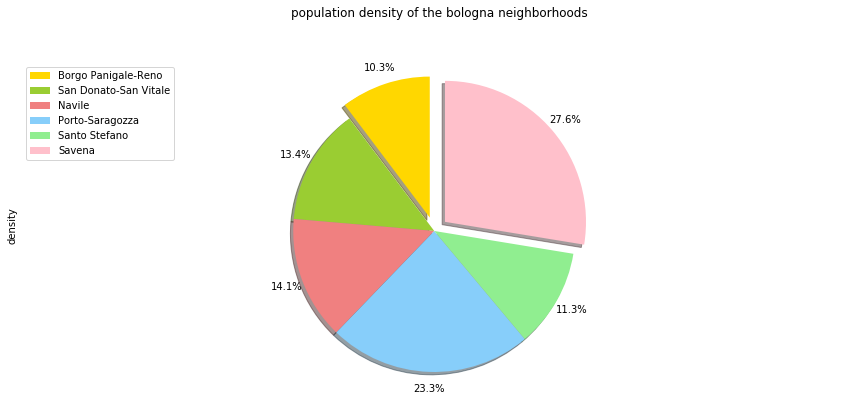

In [11]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0, 0, 0, 0.0, 0.1] # ratio for each continent with which to offset each wedge.
bologna_df['density'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('population density of the bologna neighborhoods', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=bologna_df['neighborhood'], loc='upper left') 

plt.show()

From this first analysis we realize that there are a couple of neighborhoods more crowded than the other. They are 'Savena' and 'Porto Saragozza'. So we can guess that those neighboorhood are in the downtown. We have to keep in mind this information in the future.<br/>
Let's try to retrieve the latitude and longitude of every neighborhood. This data will be added to the current dataframe.

In [12]:
geolocator = Nominatim(user_agent="bo_explorer")
longitude = []
latitude = []
for neigh in bologna_df['neighborhood']:
    address = neigh + ', Bologna, Italy'
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    #print('The geograpical coordinate of {} are {}, {}.'.format(neigh, location.latitude, location.longitude))
#print(latitude)
#print(longitude)
bologna_df['latitude'] = latitude
bologna_df['longitude'] = longitude
bologna_df.head()

,neighborhood,area,inhabitants,density,sub district,latitude,longitude
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,...",44.521942,11.271077
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,...",44.511899,11.395177
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina",44.518470,11.328901
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",44.477876,11.304899
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",44.492055,11.349035


Save the dataframe as a csv file.

In [13]:
bologna_df.to_csv(r'bologna-neigh.csv', index=False)

Why not plot a choropleth picture of the Bologna's neighborhoods? We need a geojson file. I have prepared one.

In [14]:
#  read the geojson file
bologna_geo = r'bologna.geojson' # geojson file
# create a plain bologna map
bologna_address = 'Bologna, Italy'
location = geolocator.geocode(bologna_address)
bo_latitude = location.latitude
bo_longitude = location.longitude
print('The geograpical coordinate of Bologna are {}, {}.'.format(bo_latitude, bo_longitude))

The geograpical coordinate of Bologna are 44.4936714, 11.3430347.


In [15]:
bologna_map = folium.Map(location=[bo_latitude, bo_longitude], zoom_start=12)
bologna_map

Now we want to create a `Choropleth` map of Bologna. We will use the *choropleth* method with the following main parameters:

1. geo_data, which is the GeoJSON file.
2. data, which is the dataframe containing the data.
3. columns, which represents the columns in the dataframe that will be used to create the `Choropleth` map.
4. key_on, which is the key or variable in the GeoJSON file that contains the name of the variable of interest. To determine that, you will need to open the GeoJSON file using any text editor and note the name of the key or variable that contains the name of the neighborhoods, since the neighborhoods are our variable of interest. In this case, **name** is the key in the GeoJSON file that contains the name of the neighborhoods. Note that this key is case_sensitive, so you need to pass exactly as it exists in the GeoJSON file.

In [16]:
# generate choropleth map using the density of population of the Bologna's neighborhoods
bologna_map.choropleth(
    geo_data=bologna_geo,
    data=bologna_df,
    columns=['neighborhood', 'density'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Bologna neighborhoods density'
)

# display map
bologna_map

/home/fabio/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Here we go. The Pandas Dataframe has been cleaned and now we can move further and add some more interesting informations to it.

## Define Foursquare Credentials and Version <a name="credentials"></a>

In [17]:
CLIENT_ID = 'WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI' # your Foursquare ID
CLIENT_SECRET = 'NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI
CLIENT_SECRET:NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL


Create a map of Bologna with neighborhoods superimposed on top

In [18]:
# create map of Bologna using latitude and longitude values
map_bologna = folium.Map(location=[bo_latitude, bo_longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(bologna_df['latitude'], bologna_df['longitude'], bologna_df['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bologna)
    
map_bologna

In [19]:
# instantiate a feature group for the population densities in the dataframe
densities = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(bologna_df['latitude'], bologna_df['longitude']):
    densities.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

for lat, lng, density in zip(bologna_df['latitude'], bologna_df['longitude'], bologna_df['density']):
    folium.Marker([lat, lng], popup=density).add_to(map_bologna) 
    
# add incidents to map
map_bologna

## Explore the University of Bologna's neighborhood<a name="university"></a>

First let' get the coohordinates of the University. This info will be helpful later.

In [20]:
university_address = 'Via Zamboni 33, Bologna, Italy'
location = geolocator.geocode(university_address)
university_latitude = location.latitude
university_longitude = location.longitude
print('The geograpical coordinate of Bologna University are {}, {}.'.format(university_latitude, university_longitude))

The geograpical coordinate of Bologna University are 44.4971104, 11.352995.


In [26]:
# create map of Bologna using latitude and longitude values
map_university = folium.Map(location=[university_latitude, university_longitude], zoom_start=16)

# add markers to map
university_label = '{}'.format("University of Bologna")
university_label = folium.Popup(university_label, parse_html=True)
folium.CircleMarker(
    [university_latitude, university_longitude],
    radius=15,
    popup=university_label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_university)
    
map_university

#### Now, let's get the top 100 venues that are in the Bologna university neighborhoods within a radius of 500 meters.
#### https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&radius=RADIUS&limit=LIMIT

First, let's create the GET request URL. Name your URL url.

In [27]:
# type your answer here
radius = 500
VERSION = '20180604'
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, university_latitude, university_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI&client_secret=NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL&ll=44.4971104,11.352995&v=20180604&radius=500&limit=100'

Send the GET request and examine the resutls

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea28539bae9a2001b6080fb'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Università di Bologna',
  'headerFullLocation': 'Università di Bologna, Bologna',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 33,
  'suggestedBounds': {'ne': {'lat': 44.5016104045, 'lng': 11.359292058618216},
   'sw': {'lat': 44.492610395499995, 'lng': 11.346697941381784}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51eba116498e1f30b2c435f6',
       'name': 'Museo Di Palazzo Poggi',
       'location': {'lat': 44.49691099187413,
        'lng': 11.352514220250136,
        'labeledLatLngs': [{'label': 'display',
          'lat': 44.49691099187413,


It seems that the area around the University is really full of restaurants and bars.

We now that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [36]:
venues = results['response']['groups'][0]['items']

nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng,id
0,Museo Di Palazzo Poggi,Science Museum,44.496911,11.352514,51eba116498e1f30b2c435f6
1,Hamerica's,Burger Joint,44.497246,11.353017,58bf1290d8b0ed09583b894d
2,Accademia delle Belle Arti,College Arts Building,44.498358,11.352895,4cbecf06575d236a25ddba8e
3,Teatro Comunale,Opera House,44.496524,11.349929,4c078ae18b4520a1f2038797
4,Cento3cento Veg,Vegetarian / Vegan Restaurant,44.498655,11.350813,52276b9711d22a48a5362ad4
5,Caffetteria Al Salam,Mediterranean Restaurant,44.498798,11.350818,4bb345cd42959c747ab1212c
6,Orto Botanico,Garden,44.499682,11.352944,4de3877ad164df8575143811
7,Moustache,Cocktail Bar,44.498138,11.349275,4dda8ea9b0fb8af380d03420
8,Pasticceria Dell'arte,Café,44.497536,11.348797,4df1b15dd4c01ff6b2e4c19f
9,Baracca e Burattini,Café,44.499493,11.351194,560434ae498ed26b4a185414


In [31]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

33 venues were returned by Foursquare.


Let's take a look at the tips of each venue

Define before a new function to retrieve the tips from each venue found.

In [32]:
def getVenuesTips(venue_id):
    limit = 15 # set limit to be greater than or equal to the total number of tips\n",
    tips = []
    for id, name in zip(venue_id['id'], venue_id['name']):
        url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
        result = requests.get(url).json()
        #print(result)
        try:
            tips.append(result['response']['tips']['count'])
        except:
            print('Venue {} has not tips')
    return tips

In [37]:
nearby_venues['tips'] = getVenuesTips(nearby_venues)

In [38]:
nearby_venues.head(20)

,name,categories,lat,lng,id,tips
0,Museo Di Palazzo Poggi,Science Museum,44.496911,11.352514,51eba116498e1f30b2c435f6,7
1,Hamerica's,Burger Joint,44.497246,11.353017,58bf1290d8b0ed09583b894d,4
2,Accademia delle Belle Arti,College Arts Building,44.498358,11.352895,4cbecf06575d236a25ddba8e,3
3,Teatro Comunale,Opera House,44.496524,11.349929,4c078ae18b4520a1f2038797,13
4,Cento3cento Veg,Vegetarian / Vegan Restaurant,44.498655,11.350813,52276b9711d22a48a5362ad4,15
5,Caffetteria Al Salam,Mediterranean Restaurant,44.498798,11.350818,4bb345cd42959c747ab1212c,10
6,Orto Botanico,Garden,44.499682,11.352944,4de3877ad164df8575143811,7
7,Moustache,Cocktail Bar,44.498138,11.349275,4dda8ea9b0fb8af380d03420,23
8,Pasticceria Dell'arte,Café,44.497536,11.348797,4df1b15dd4c01ff6b2e4c19f,5
9,Baracca e Burattini,Café,44.499493,11.351194,560434ae498ed26b4a185414,3


In [46]:
# create map of Bologna using latitude and longitude values
map_university = folium.Map(location=[university_latitude, university_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, tips in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['tips']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=tips/3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_university)
    
map_university

## Explore Bologna's Neighborhoods<a name="exploreneighborhoods"></a>

#### Let's create a function to repeat the same process to all the neighborhoods in Bologna

In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *bologna_venues*.

In [48]:
bologna_venues = getNearbyVenues(names=bologna_df['neighborhood'],
                                   latitudes=bologna_df['latitude'],
                                   longitudes=bologna_df['longitude']
                                  )

Borgo Panigale-Reno
San Donato-San Vitale
Navile
Porto-Saragozza
Santo Stefano
Savena


#### Let's check the size of the resulting dataframe

In [49]:
print(bologna_venues.shape)
bologna_venues.head(50)

(105, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Borgo Panigale-Reno,44.521942,11.271077,Hotel del Borgo,44.520342,11.266867,Hotel
1,Borgo Panigale-Reno,44.521942,11.271077,Trattoria della Salute,44.524890,11.274950,Restaurant
2,Borgo Panigale-Reno,44.521942,11.271077,Hostaria dei 4 Gatti,44.518868,11.270852,Pub
3,Borgo Panigale-Reno,44.521942,11.271077,Piscina Cavina,44.522394,11.269097,Pool
4,Borgo Panigale-Reno,44.521942,11.271077,Ristorante Il Desiderio,44.520100,11.267480,Italian Restaurant
5,Borgo Panigale-Reno,44.521942,11.271077,Caffè Le Fate,44.521278,11.272337,Café
6,Borgo Panigale-Reno,44.521942,11.271077,Centro Sportivo Cavina,44.522265,11.269022,Soccer Field
7,Borgo Panigale-Reno,44.521942,11.271077,Bar Grillo,44.525043,11.274891,Café
8,San Donato-San Vitale,44.511899,11.395177,CASA,44.514818,11.398246,Furniture / Home Store
9,San Donato-San Vitale,44.511899,11.395177,Fashion & Fitness,44.514837,11.398441,Gym / Fitness Center


Let's check how many venues were returned for each neighborhood

In [50]:
bologna_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Borgo Panigale-Reno,8,8,8,8,8,8
Navile,18,18,18,18,18,18
Porto-Saragozza,4,4,4,4,4,4
San Donato-San Vitale,18,18,18,18,18,18
Santo Stefano,49,49,49,49,49,49
Savena,8,8,8,8,8,8


The 'Santo Stefano' neighborhood is the most crowded for sure! I guess that this is the most interesting area where opening my Sushi Bar.

#### Let's find out how many unique categories can be curated from all the returned venues

In [51]:
print('There are {} uniques categories.'.format(len(bologna_venues['Venue Category'].unique())))

There are 54 uniques categories.


## Analyze Each Neighborhood<a name="analyzeneighborhoods"></a>

In [52]:
# one hot encoding
bologna_onehot = pd.get_dummies(bologna_venues[['Venue Category']], prefix="", prefix_sep="")

# get neighborhood column to a temporary dataframe
bologna_onehot['Neighborhood'] = bologna_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [bologna_onehot.columns[-1]] + list(bologna_onehot.columns[:-1])
bologna_onehot = bologna_onehot[fixed_columns]

Let's take a look at the dataframe's size

In [53]:
bologna_onehot.shape

(105, 55)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
bologna_onehot_grouped = bologna_onehot.groupby('Neighborhood').mean().reset_index()
bologna_onehot_grouped

,Neighborhood,Asian Restaurant,Bakery,Bar,Bistro,Brewery,Butcher,Café,Candy Store,Cheese Shop,...,Shopping Mall,Skate Park,Soccer Field,Soccer Stadium,Sporting Goods Shop,Supermarket,Theater,Vegetarian / Vegan Restaurant,Wine Bar,Women's Store
0,Borgo Panigale-Reno,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.125,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,Navile,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.055556,0.000000,...,0.055556,0.055556,0.000,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.055556
2,Porto-Saragozza,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,San Donato-San Vitale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.055556,0.000000,0.000,0.000000,0.055556,0.00,0.055556,0.000000,0.000000,0.000000
4,Santo Stefano,0.000000,0.040816,0.040816,0.040816,0.020408,0.020408,0.040816,0.000000,0.020408,...,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.020408,0.020408,0.061224,0.000000
5,Savena,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size

In [55]:
bologna_onehot_grouped.shape

(6, 55)

#### Let's print each neighborhood along with the top 5 most common venues

In [56]:
num_top_venues = 5

for hood in bologna_onehot_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bologna_onehot_grouped[bologna_onehot_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Borgo Panigale-Reno----
        venue  freq
0        Café  0.25
1  Restaurant  0.12
2       Hotel  0.12
3        Pool  0.12
4         Pub  0.12


----Navile----
              venue  freq
0              Café  0.11
1  Asian Restaurant  0.06
2  Department Store  0.06
3    Soccer Stadium  0.06
4        Skate Park  0.06


----Porto-Saragozza----
               venue  freq
0     Scenic Lookout  0.50
1               Park  0.25
2  Food & Drink Shop  0.25
3   Asian Restaurant  0.00
4                Pub  0.00


----San Donato-San Vitale----
                    venue  freq
0          Clothing Store  0.11
1  Furniture / Home Store  0.11
2       Electronics Store  0.06
3    Fast Food Restaurant  0.06
4          Sandwich Place  0.06


----Santo Stefano----
                venue  freq
0  Italian Restaurant  0.18
1               Plaza  0.10
2      Ice Cream Shop  0.08
3            Wine Bar  0.06
4      Sandwich Place  0.06


----Savena----
               venue  freq
0                Gym  0.25
1   

At a first glance Santo Stefano is full of restaurants, ice cream shops, Coffee bars, Wine Bars. I can firmly assume that this area is in good consideration to open the new sushi bar. Anyway let's try to dive more in depth the venues located in the neighborhoods.

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [58]:
num_top_venues = 12

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bologna_onehot_grouped['Neighborhood']

for ind in np.arange(bologna_onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bologna_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(6)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue
0,Borgo Panigale-Reno,Café,Hotel,Soccer Field,Italian Restaurant,Pub,Restaurant,Pool,Butcher,Brewery,Furniture / Home Store,Food Stand,Food & Drink Shop
1,Navile,Café,Women's Store,Pizza Place,Candy Store,Cosmetics Shop,Department Store,Food Stand,Gastropub,Ice Cream Shop,Italian Restaurant,Mobile Phone Shop,Park
2,Porto-Saragozza,Scenic Lookout,Food & Drink Shop,Park,Women's Store,Cupcake Shop,Grocery Store,Gastropub,Furniture / Home Store,Food Stand,Fish Market,Fast Food Restaurant,Emilia Restaurant
3,San Donato-San Vitale,Clothing Store,Furniture / Home Store,Pizza Place,Sandwich Place,Park,Pharmacy,Pool,Department Store,Electronics Store,Café,Shopping Mall,Fast Food Restaurant
4,Santo Stefano,Italian Restaurant,Plaza,Ice Cream Shop,Sandwich Place,Wine Bar,Bakery,Bar,Bistro,Café,Monument / Landmark,Cupcake Shop,Chinese Restaurant
5,Savena,Supermarket,Gym,Bar,Italian Restaurant,Park,Emilia Restaurant,Women's Store,Department Store,Gastropub,Furniture / Home Store,Food Stand,Food & Drink Shop


## Considerations<a name="someconsiderations"></a>
* 'Santo Stefano' is full of Italian restaurants, Bars, Bistros, Ice cream shop. Further 'Santo Stefano' has the lowest density of population. It means that this is a touristic area, not a residential one.
* "Santo Donato - San Vitale" neighborhood is equipped with many appliance stores, music, fast food restaurants, and a mall. It therefore looks like a commercial area where people go shopping and maybe consume something. It does not seem suitable for opening a high-level place aimed at young people.
* The area named 'Porto Saragozza' is a re residential zone. If offers a mix of food shops, markets, restaurants, electronic stores. It is not interesting to open a Sushi Bar.
* The area 'Navile' could be a good candidate: some Asian Restaurants, Coffee Bars, Gastropub, Italian Restaurants. I'd like to place my Sushi Bar closer to other Asian restaurants, I could grab them some customers...
* Borgo Panigale is too far from the downtown. In addition it seems to be a residential area.
* Savena has the highest density of population. So I guess this is not a touristic area. I will not take it into consideration.

So at the end of day the choice will be between 'Santo Stefano' and 'Navile'. I need some criteria to take the final decision. Let's try to understand how each is far from university.

In [59]:
from math import radians, sin, cos, acos
#dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))

In [60]:
def getNeighDistanceFromUniversity(university_lat, university_long, latitudes, longitudes):
    dist = []
    for elat, elon in zip(latitudes, longitudes):
        dist.append(6371.01 * acos(sin(university_lat)*sin(elat) + cos(university_lat)*cos(elat)*cos(university_long - elon)))
    return dist

In [61]:
distances = getNeighDistanceFromUniversity(university_latitude, university_longitude,
                                   latitudes=bologna_df['latitude'],
                                   longitudes=bologna_df['longitude']
                                  )
#print(distances)
bologna_df['distances'] = distances
bologna_df.head(6)

,neighborhood,area,inhabitants,density,sub district,latitude,longitude,distances
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,...",44.521942,11.271077,477.917737
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,...",44.511899,11.395177,251.247506
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina",44.518470,11.328901,190.131989
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",44.477876,11.304899,294.806407
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",44.492055,11.349035,39.000077
5,Savena,11.469,59810.0,5214.927195,"Mazzini, San Ruffillo, Fossolo, Pontevecchio, ...",44.466926,11.376817,233.931813


Woow! Santo Stefano is really close to the University. This means that there is a lot of young people nearby ....
So defintely I decide to select Santo Stefano as location for the new Sushi Bar. Here below a shor description of the area.

## Santo Stefano<a name="santostefano"></a>
This area is considered the richest in the city, the wealth that has characterized the neighborhood since the beginning gives young inhabitants the stereotype of a medium-high lifestyle, with fashionable clothing, expensive cars and the use of luxury products . Furthermore, property prices in this area are to be considered the highest in the entire metropolitan area of Bologna.

The neighborhood is known for being one of the most elegant areas of the city. Here, in fact, many families belonging to the Bolognese high society lived and still live there. The historic buildings, some still owned by these well-known families, are distributed on the right and left of the street starting from the door and then reaching the homonymous square (voted among the most beautiful in Italy).

Let's search for the 'Restaurants' in the 'Santo Stefano' area.

In [62]:
search_query = 'Sushi'
radius = 500
print(search_query + ' .... OK!')
santostefano=bologna_df[bologna_df['neighborhood'] == "Santo Stefano"]
latitude=santostefano['latitude'].values[0]
longitude=santostefano['longitude'].values[0]
print("Santo Stefano cohordinates {} {}".format(latitude, longitude))

Sushi .... OK!
Santo Stefano cohordinates 44.492055 11.3490347


In [63]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI&client_secret=NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL&ll=44.492055,11.3490347&v=20180604&query=Sushi&radius=500&limit=100'

#### Send the GET Request and examine the results

In [64]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea2918902a17200204a5fe9'},
 'response': {'venues': [{'id': '59bc36bf603d2a17e32db517',
    'name': 'Seta Sushi Lab',
    'location': {'address': 'Corte Isolani',
     'lat': 44.493291,
     'lng': 11.348653,
     'labeledLatLngs': [{'label': 'display',
       'lat': 44.493291,
       'lng': 11.348653}],
     'distance': 140,
     'postalCode': '40125',
     'cc': 'IT',
     'city': 'Bologna',
     'state': 'Emilia-Romagna',
     'country': 'Italia',
     'formattedAddress': ['Corte Isolani',
      '40125 Bologna Emilia-Romagna',
      'Italia']},
    'categories': [{'id': '4bf58dd8d48988d1d2941735',
      'name': 'Sushi Restaurant',
      'pluralName': 'Sushi Restaurants',
      'shortName': 'Sushi',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/sushi_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1587712942',
    'hasPerk': False},
   {'id': '50cb29b3e4b044ef5db90f43',
    'name': 'Arigato Wok Su

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [65]:
try:
    from collections import OrderedDict
except ImportError:
    from ordereddict import OrderedDict
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
sushi_df = pd.json_normalize(venues)
sushi_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,59bc36bf603d2a17e32db517,Seta Sushi Lab,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",v-1587712942,False,Corte Isolani,44.493291,11.348653,"[{'label': 'display', 'lat': 44.493291, 'lng':...",140,40125,IT,Bologna,Emilia-Romagna,Italia,"[Corte Isolani, 40125 Bologna Emilia-Romagna, ..."
1,50cb29b3e4b044ef5db90f43,Arigato Wok Sushi,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1587712942,False,NaN,44.495333,11.346369,"[{'label': 'display', 'lat': 44.4953325, 'lng'...",421,NaN,IT,NaN,NaN,Italia,[Italia]
2,5c9fb60535d3fc002c7f877c,Sushiman,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",v-1587712942,False,via san vitale 4/d,44.494460,11.347601,"[{'label': 'display', 'lat': 44.49446, 'lng': ...",290,40125,IT,Bologna,Emilia-Romagna,Italia,"[via san vitale 4/d, 40125 Bologna Emilia-Roma..."


#### Define information of interest and filter dataframe

#### Let's visualize the Sushi restaurants that are nearby

In [66]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in sushi_df.columns if col.startswith('location.')] + ['id']
sushi_df_filtered = sushi_df.loc[:, filtered_columns]

#dataframe_filtered.head()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
sushi_df_filtered['categories'] = sushi_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
sushi_df_filtered.columns = [column.split('.')[-1] for column in sushi_df_filtered.columns]

sushi_df_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Seta Sushi Lab,Sushi Restaurant,Corte Isolani,44.493291,11.348653,"[{'label': 'display', 'lat': 44.493291, 'lng':...",140,40125,IT,Bologna,Emilia-Romagna,Italia,"[Corte Isolani, 40125 Bologna Emilia-Romagna, ...",59bc36bf603d2a17e32db517
1,Arigato Wok Sushi,Chinese Restaurant,NaN,44.495333,11.346369,"[{'label': 'display', 'lat': 44.4953325, 'lng'...",421,NaN,IT,NaN,NaN,Italia,[Italia],50cb29b3e4b044ef5db90f43
2,Sushiman,Sushi Restaurant,via san vitale 4/d,44.494460,11.347601,"[{'label': 'display', 'lat': 44.49446, 'lng': ...",290,40125,IT,Bologna,Emilia-Romagna,Italia,"[via san vitale 4/d, 40125 Bologna Emilia-Roma...",5c9fb60535d3fc002c7f877c


In [68]:
sushi_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Santo Stefano',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(sushi_map)

# add the Sushi restaurants as blue circle markers
for lat, lng, label in zip(sushi_df_filtered['lat'], sushi_df_filtered['lng'], sushi_df_filtered['name']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(sushi_map)

# display map
sushi_map

The Sushi restaurants are located in a small area. It's reasonable to take a shop for rent in the same area if we want to grab the customers from them.

I would like to understand the age of the customers of the  current Sushi bars. For example let's start to read the tips of the first one.

In [119]:
sushibars=sushi_df_filtered[['id', 'name']]
sushibars.head()

,id,name
0,59bc36bf603d2a17e32db517,Seta Sushi Lab
1,50cb29b3e4b044ef5db90f43,Arigato Wok Sushi
2,5c9fb60535d3fc002c7f877c,Sushiman


In [163]:
def getVenuesPrice(venue):
    price = []
    for id, name in zip(venue['id'], venue['name']):
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        #print(result['response']['venue']['id'])
        try:
            if result['response']['venue']['price']['message']:
                price.append(result['response']['venue']['price']['message'])
            else:
                price.append("no price evaluation")
        except:
            print('This venue has not been rated yet.')
    return price

In [169]:
sushibars['price'] = getVenuesPrice(sushibars)
sushibars = sushibars.drop(['id'], axis=1)
sushibars.head()

/home/fabio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,name,price
0,Seta Sushi Lab,Expensive
1,Arigato Wok Sushi,Moderate
2,Sushiman,Expensive


In [165]:
def getVenuesTips(venue_id):
    limit = 15 # set limit to be greater than or equal to the total number of tips\n",
    tips = []
    for id, name in zip(venue_id['id'], venue_id['name']):
        url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
        result = requests.get(url).json()
        try:
            tips.append(result['response']['tips']['count'])
        except:
            print('This venue has not tips')
    return tips

In [166]:
tips = getVenuesTips(sushi_id)
print(tips)

[1, 0, 0]


It seems that just one of them has tips....It's good for us...My Sushi bar will have millions of tips!!

## Conclusion<a name="conclusion"></a>

* The goal of the analysis was to identify a location where to open a Sushi Bar in Bologna.<br/>
* I have the ambition to open the new restaurant in the most exclusive area of Bologna. 
* It would be nice if the location was close to the university because this would attract many young people.

The first problem was to identify the neighborhoods of the city of Bologna. The data were taken from a wikipedia page (https://it.wikipedia.org/wiki/Quartieri_di_Bologna). After some cleaning I was able to have a dataframe with some information for each Bologna neighborhood.

The information available for each neighborhood is listed below:
* neighborhood name
* area 
* inhabitants 
* density 
* sub district

A graphical representation (both as a pie chart and as a choropleth) of the population density by neighborhood was therefore provided: it is a very important parameter for choosing the place to rent.
Therefore neighborhoods with high density and others with clearly lower density have been identified.
A neighborhood with a high density of resident population is not said to be frequented by many tourists. It could be a residential neighborhood and therefore not suitable for the opening of a trendy restaurant.

Using the APIs provided by Foursquare it was possible to explore the main points of interest of each neighborhood. By performing a groupby of the result, it was possible to deduce that the Santo Stefano district is certainly the one with the highest number of points of interest.

For each venue, the 5 main attractions were listed (those with the highest frequency) and therefore considerations were made regarding the different types of points of interest.

From this analysis, the choice was reduced to a couple of neighborhoods: Santo Stefano and Navile.

To understand who to choose we need another criterion of analysis. Since we want our new Sushi Bar to be frequented by young people, we try to calculate the distance of each of the two districts from the famous university of Bologna, one of the most ancient in Italy.

Doing that we have realized that the university is inside the area of Santo Stefano. So that will be our choice.

In order to identify the most suitable area of Santo Stefano to open a Sushi Bar we performed another search using the Foursquare API. We realized that in the Santo Stefano district there is an area near the university with 3 Sushi restaurants. In any case, if we want to try to steal customers from these restaurants, it makes sense to open the Sushi bar near other Japanese restaurants. We will certainly do better!